# Notebook created 17.02.2025


In [197]:
#imports to be used later on
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib.cm import get_cmap
from astropy.io import fits
import matplotlib
import scipy.ndimage
import scipy.interpolate
from astropy.table import Table
import astropy.units as u
%matplotlib inline

import math
import matplotlib.patches as patches

import random

# # gala
# import gala.coordinates as gc
# import gala.dynamics as gd
# import gala.potential as gp
# from gala.units import galactic
# import gala.integrate as gi
# from gala.units import galactic, UnitSystem

import astropy.coordinates as coord
from astropy.coordinates import SkyOffsetFrame 
from astropy.wcs import WCS
plt.ioff

from scipy.optimize import minimize

# import reproject

from scipy.interpolate import interp1d

# Default gala cosmology: # WMAP7 cosmology in effect
from astropy import cosmology
cosmo = cosmology.default_cosmology.get()


# # Import all the functions needed for fitting + stream generating etv
# import CenA_functions as CenA

In [2]:
path = '/Users/hzg129/Desktop/Research2024/CENA/'
plot_path = '/Users/spearson/Desktop/Research/CenA/CenA2021/plots/'

In [427]:
mpl.rcParams.update({'font.size': 20})
label_size = 20
mpl.rcParams['xtick.labelsize'] = 18#label_size 
mpl.rcParams['ytick.labelsize'] =18#label_size a

# Data 

In [4]:
#path = '/Users/spearson/Desktop/Research/CenA/'
hdulist = fits.open(path + 'CenA_rgbmap_msolpc2.fits')
hdulist.info()
hdulist[0].data
hdr = dict(hdulist[0].header)
image = hdulist[0].data
wcs_input_dict = hdulist[0].header
wcs_helix_dict = WCS(wcs_input_dict)
header = hdulist[0].header
wcs_helix = WCS(header)

#getting rid of 0's from image data for imshow lognorm to work
j = 0
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if image[i,j] == 0.:
            image[i,j] = 10**-10
            j = j+1

# j = 0
# for i in range(image.shape[0]):
#     for j in range(image.shape[1]):
#         if math.isnan(image[i,j]):
#             print('it is nan')
#             image[i,j] = 10**-10
#             j = j+1





Filename: /Users/hzg129/Desktop/Research2024/CENA/CenA_rgbmap_msolpc2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   (456, 424)   float64   


In [5]:
# #Test for histogram for Fiona. 

In [6]:
#header

In [7]:
image_fill = np.ones([426,456])*10**-10

# Plot data

Text(401, 28, '30 kpc')

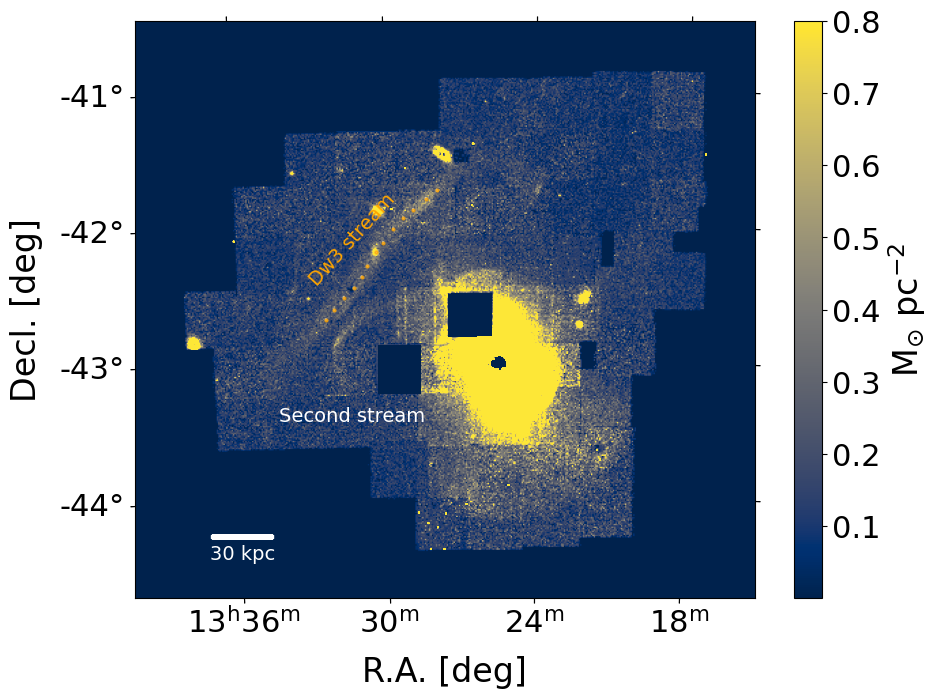

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_helix)
#plt.imshow(image_fill, origin='lower', cmap='cividis', norm=LogNorm(),vmin =0.01, vmax = 10, aspect='equal', rasterized=True)
plt.imshow(image, origin='lower', cmap='cividis',  aspect='equal', rasterized=True,vmin =0.00001, vmax = 0.8)
plt.xlabel(r'R.A. [deg]')
plt.ylabel(r'Decl. [deg]')
plt.colorbar(label='M$_{\odot}$ pc$^{-2}$', shrink=0.75)



control_points_new = coord.SkyCoord([203.1,\
    202.585167, 202.675, 202.735,202.816, 202.916, 203.016, \
                                 202.515, 202.415, 202.315, 202.215, 202.09,\
                                    201.98]*u.deg, \
                                [-42.68,\
    -42.191741,-42.29,-42.37, -42.45,-42.52,-42.61, \
                                 -42.12, -42.02, -41.94,  -41.88, -41.8,\
                                 -41.74,]*u.deg)


ra_err_new =  np.ones(len(control_points_new.ra.deg))*0.01
dec_err_new =  np.ones(len(control_points_new.dec.deg))*0.01
plt.errorbar(control_points_new.ra.deg, control_points_new.dec.deg,yerr=dec_err_new, xerr=None,\
             fmt='.', color='orange',markersize=4,alpha=0.7,ecolor='white',transform=ax.get_transform('icrs'), rasterized=True)

# plt.errorbar(control_SS.ra.deg, control_SS.dec.deg,yerr=0.01, xerr=None,\
#              fmt='.', color='white',markersize=4,alpha=0.7,ecolor='white',transform=ax.get_transform('icrs'), rasterized=True)




plt.text(350,130,'Second stream', rotation=0, size=14, color='white', rasterized=True)
plt.text(330,230,'Dw3 stream', rotation=47.76, size=14, color='orange', rasterized=True)

ax.set_ylim([0,424])
ax.set_xlim([456,0])

plt.fill_between([400,354],44,46, color='white', rasterized=True)
plt.text(401,28, '30 kpc', color='white', fontsize=14, rasterized=True)
    
#fig.tight_layout()
#fig.savefig(path + 'CenA2021/plots/Fig1_paper.pdf', dpi=300)


In [9]:
#Test for histogram for Fiona 

## Try changing your threshold and bin_factor to change spacing of the red points you will use as input to your data.

Changing the bin factor will also change the value in each pixel (try visualizing plt.imshow(rebinned_binary, origin='lower', cmap='binary', aspect='auto'))

In [242]:
threshold = 0.44
binary_mask = np.where(image > threshold, 1, 0)

In [248]:
bin_factor = 4  # Change this to control bin size

y_size, x_size = binary_mask.shape
new_y, new_x = y_size // bin_factor, x_size // bin_factor


In [249]:
# Rebin the mask: sum over bin_factor × bin_factor regions
rebinned = binary_mask[:new_y * bin_factor, :new_x * bin_factor]  # Trim excess
rebinned = rebinned.reshape(new_y, bin_factor, new_x, bin_factor).sum(axis=(1, 3))

# Normalize to binary (1 if any value > 0 in bin)
rebinned_binary = np.where(rebinned > 0, 1, 0)

# Compute bin centers
x_centers = (np.arange(new_x) + 0.5) * bin_factor
y_centers = (np.arange(new_y) + 0.5) * bin_factor

# Find bin centers where rebinned_binary == 1
y_idx, x_idx = np.where(rebinned_binary == 1)
x_pts = x_centers[x_idx]
y_pts = y_centers[y_idx]



## Now make 2dhistogram of only ones and zeros based on bin_factor and threshold above

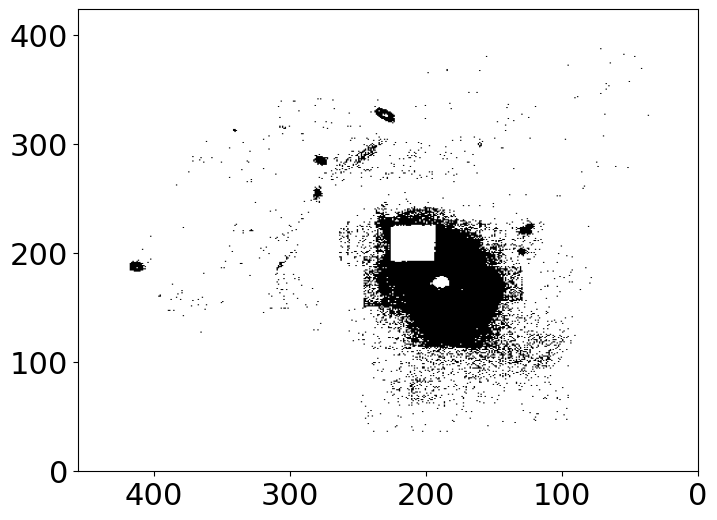

In [250]:
plt.figure(figsize=(8, 6))
plt.imshow(binary_mask, origin='lower', cmap='binary', aspect='auto')
#plt.imshow(rebinned_binary, origin='lower', cmap='binary', aspect='auto')
#plt.scatter(x_pts, y_pts, color='red', s=4, label="Bin Centers")
plt.gca().invert_xaxis()  # Match FITS convention
plt.show()

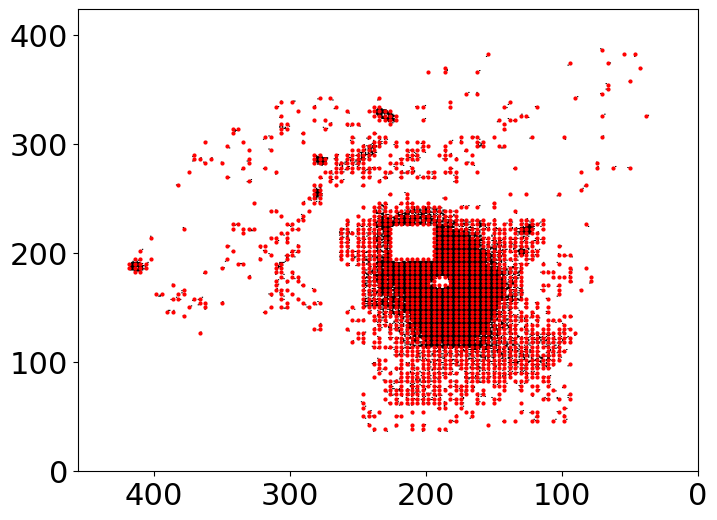

In [251]:
plt.figure(figsize=(8, 6))
plt.imshow(binary_mask, origin='lower', cmap='binary', aspect='auto')
#plt.imshow(rebinned_binary, origin='lower', cmap='binary', aspect='auto')
plt.scatter(x_pts, y_pts, color='red', s=4, label="Bin Centers")
plt.gca().invert_xaxis()  # Match FITS convention
plt.show()

In [252]:
from matplotlib.path import Path

## Define a mask region (here polygon) to only select points that are over the threshold for the actual stream (ie ignore the background and host galaxy)

In [253]:
#select coordinates to include your stream in mask
#change pixel values below to mach your data
polygon_vertices = np.array([
    [345,180],  # (x, y) points
    [325, 180],
    [220, 305],
    [250, 305]
])

In [254]:
polygon_path = Path(polygon_vertices)
xx, yy = np.meshgrid(np.arange(x_size), np.arange(y_size))  # Pixel coordinates
# Flatten and check which points are inside polygon
coords = np.vstack((xx.flatten(), yy.flatten())).T
inside_polygon = polygon_path.contains_points(coords).reshape(binary_mask.shape)

# Apply polygon mask to binary_mask
#binary_mask[~inside_polygon] = 0  # Set pixels outside polygon to 0

bin_coords = np.vstack((x_pts, y_pts)).T
inside_bin_polygon = polygon_path.contains_points(bin_coords)

# Keep only points inside the polygon
x_pts_filtered = x_pts[inside_bin_polygon]
y_pts_filtered = y_pts[inside_bin_polygon]

## Use the red points below and transform to galactocentric frame in your reference system

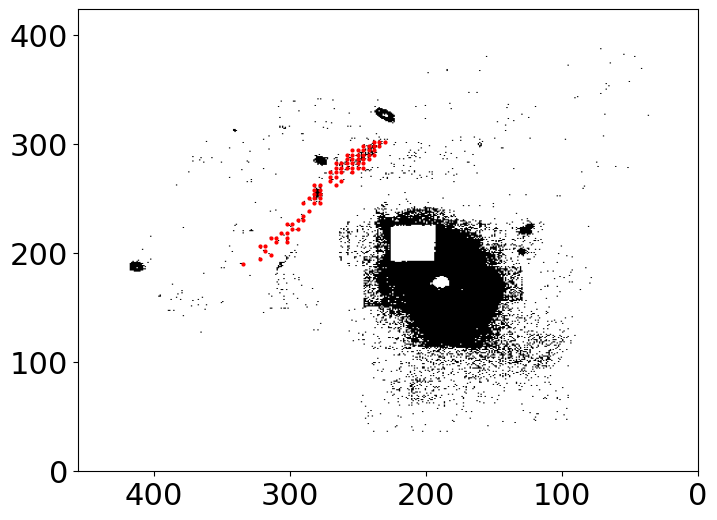

In [255]:
plt.figure(figsize=(8, 6))
#plt.imshow(rebinned_binary , origin='lower', cmap='binary', aspect='auto')
plt.imshow(binary_mask, origin='lower', cmap='binary', aspect='auto')
plt.scatter(x_pts_filtered, y_pts_filtered, color='red', s=4, label="Bin Centers")
#plt.scatter(x_pts, y_pts, color='red', s=4, label="Bin Centers")
plt.gca().invert_xaxis()  # Match FITS convention
plt.show()

## Next steps are to transform the red points to the galactocentric frames youd defined for your host galaxy. 

x_pts_filtered, y_pts_filtered are the coordinates you want but you want them first in ra/dec and then in the galactocentric frame of your host galaxy as we discussed reg. astropy

In [256]:
# Convert pixel coordinates to RA/Dec
ra_pts, dec_pts = wcs_helix.all_pix2world(x_pts_filtered, y_pts_filtered, 1)  # 0 = zero-based indexing
#print(ra_pts, dec_pts)

In [257]:
# Convert RA/Dec to ICRS using astropy.coordinates
#from astropy.coordinates import SkyCoord

red_points_icrs_coords = coord.SkyCoord(ra=ra_pts * u.deg, dec=dec_pts * u.deg)# frame='icrs')

In [258]:
#icrs_coords

### Sanity check to see if these red points overlap with the stream (did transformation work?)

Text(401, 28, '30 kpc')

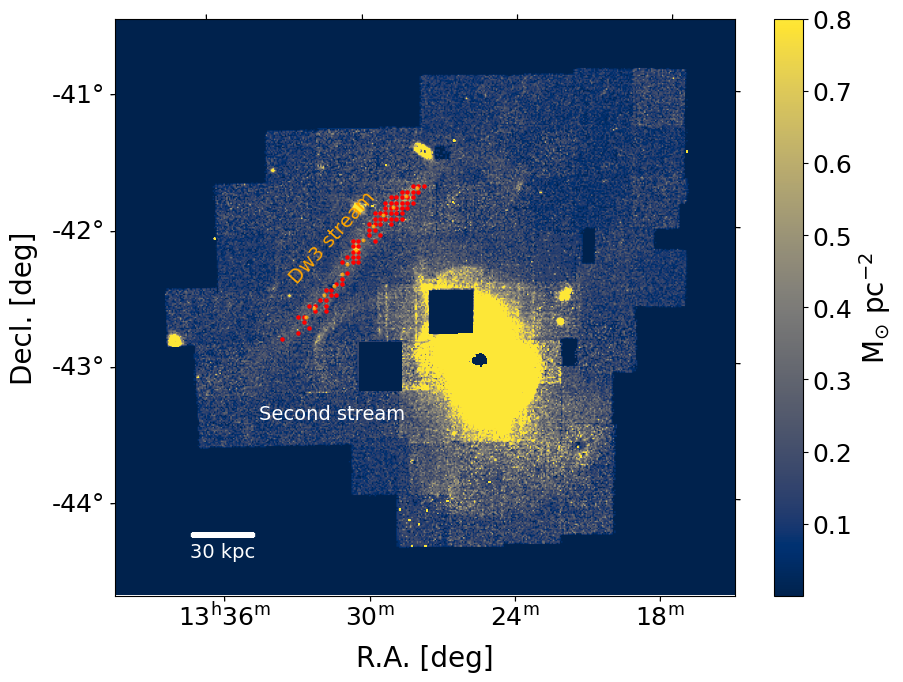

In [433]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_helix)
#plt.imshow(image_fill, origin='lower', cmap='cividis', norm=LogNorm(),vmin =0.01, vmax = 10, aspect='equal', rasterized=True)
plt.imshow(image, origin='lower', cmap='cividis',  aspect='equal', rasterized=True,vmin =0.00001, vmax = 0.8)
plt.xlabel(r'R.A. [deg]')
plt.ylabel(r'Decl. [deg]')
plt.colorbar(label='M$_{\odot}$ pc$^{-2}$', shrink=0.75)



control_points_new = coord.SkyCoord([203.1,\
    202.585167, 202.675, 202.735,202.816, 202.916, 203.016, \
                                 202.515, 202.415, 202.315, 202.215, 202.09,\
                                    201.98]*u.deg, \
                                [-42.68,\
    -42.191741,-42.29,-42.37, -42.45,-42.52,-42.61, \
                                 -42.12, -42.02, -41.94,  -41.88, -41.8,\
                                 -41.74,]*u.deg)


ra_err_new =  np.ones(len(control_points_new.ra.deg))*0.01
dec_err_new =  np.ones(len(control_points_new.dec.deg))*0.01
plt.errorbar(control_points_new.ra.deg, control_points_new.dec.deg,yerr=dec_err_new, xerr=None,\
             fmt='.', color='orange',markersize=4,alpha=0.7,ecolor='white',transform=ax.get_transform('icrs'), rasterized=True)


plt.scatter(red_points_icrs_coords.ra.deg, red_points_icrs_coords.dec.deg, color='red', s=5, transform=ax.get_transform('icrs'))

plt.text(350,130,'Second stream', rotation=0, size=14, color='white', rasterized=True)
plt.text(330,230,'Dw3 stream', rotation=47.76, size=14, color='orange', rasterized=True)

ax.set_ylim([0,424])
ax.set_xlim([456,0])

plt.fill_between([400,354],44,46, color='white', rasterized=True)
plt.text(401,28, '30 kpc', color='white', fontsize=14, rasterized=True)
    
#fig.tight_layout()
#fig.savefig(path + 'CenA2021/plots/Fig1_paper.pdf', dpi=300)


## Then convert ra_pts, dec_pts to galactocentric frame for your host galaxy

In [434]:
#Distance to host
CenA_distance = 3.8 * u.Mpc# 3.8*u.Mpc
#distance to stream progenitor (in your case the same as the host distance)
dw3_distance = 3.88* u.Mpc
#Setting alpha to 0 since we don't need to align stream coordinate system with horizontal axis in this work
alpha = 0*u.deg

In [435]:


#dw3_distance = lnL_input[0]*u.Mpc

#First use distance to define skycoords of Cen A in ICRS
#Cen A skypos
c_CenA = coord.SkyCoord(ra = 201.365063*u.deg, dec =-43.019113*u.deg,\
                    distance = CenA_distance )

# Ans also the Dw3 in ICRS
# dwarf pos

pos = coord.SkyCoord(ra=202.585167*u.deg, dec=-42.191741*u.deg,\
                     distance = dw3_distance)

red_points = coord.SkyCoord(ra=ra_pts *u.deg, dec=dec_pts *u.deg,\
                     distance = dw3_distance)


# Define CenA frame
# Frame to simulate stream in
# Milky Way is along the z-axis x and y axes are 
# oriented with the Cen A stream from Dwarf III
# First need galactocentric frame to simulate stream in
class CenAGalactocentric(coord.BaseCoordinateFrame):
    """
    Position at the center of Cen A

    Milky Way is along the z-axis
    x and y axes are oriented with the Cen A stream from Dwarf III
    
    
    SP checked above, and it seems like it's x and vx that points towards MW
    """

    default_representation = coord.CartesianRepresentation
    default_differential = coord.CartesianDifferential

    # Frame attributes
    CenA_sky_coord = coord.CoordinateAttribute(
        frame=coord.ICRS,
        default=coord.SkyCoord(c_CenA.ra.deg, c_CenA.dec.deg, unit=u.deg)
    )

    CenA_distance = coord.QuantityAttribute(
        default=CenA_distance,# * u.Mpc,
        unit=u.Mpc
    )

    alpha = coord.QuantityAttribute(
        default=alpha,
        unit=u.deg
       
    )

#Don't fully understand if I need the below for the angle, I already do this in the skyoffset frame
from astropy.coordinates.matrix_utilities import rotation_matrix

def get_icrs_to_cena_transform(cena_frame, icrs_frame, inverse=False):
    """
    Get the transformation matrix to go from ICRS to Cen A coordinates.

    Note: Currently this only does positions correctly
    """
   # print(alpha)
    # Rotation matrix to go from CenA to ICRS
    Rz = rotation_matrix(-cena_frame.CenA_sky_coord.ra, 'z')
    Ry = rotation_matrix(cena_frame.CenA_sky_coord.dec, 'y')
    Rx = rotation_matrix(cena_frame.alpha, 'x')
    R = Rz @ Ry @ Rx

    # Positional offset to the center of Cen A (from ICRS)
    dpos = coord.CartesianRepresentation(cena_frame.CenA_distance * [1., 0, 0])

    if inverse:  # Cen A to ICRS
        A = R
        b = (dpos).transform(A)

    else:  # ICRS to Cen A
        A = R.T
        b = -dpos

    return A, b


@coord.frame_transform_graph.transform(
    coord.transformations.AffineTransform,
    coord.ICRS,
    CenAGalactocentric
)
def icrs_to_cena(icrs_coord, cena_frame):
    return get_icrs_to_cena_transform(cena_frame, icrs_coord)


@coord.frame_transform_graph.transform(
    coord.transformations.AffineTransform,
    CenAGalactocentric,
    coord.ICRS
)
def cena_to_icrs(cena_coord, icrs_frame):
    return get_icrs_to_cena_transform(cena_coord, icrs_frame, inverse=True)


# Transform red points to galacticentric frame
red_points_GC = red_points.transform_to(CenAGalactocentric())
# Use CenA Galactocentric frame to get stream progenitor position (one coord should be close to 0 in your case)
dw3_pos_GC = pos.transform_to(CenAGalactocentric())
#sanity check that host galaxy Cen A is at (0,0,0)
c_CenA_GC = c_CenA.transform_to(CenAGalactocentric())

In [424]:
# Save dw center in array as you need this info as input for stream fitting method later
# "hack" below to create a coordinate system where the skyplane is in x,z 
# and the perpendicular (line-of-sight, los) directions is along the y axis
dw3_center = np.array([-dw3_pos_GC.y.to(u.kpc).value,dw3_pos_GC.x.to(u.kpc).value, dw3_pos_GC.z.to(u.kpc).value])
# for plotting purposes below (just 0,0,0)
c_CenA_center = np.array([-c_CenA_GC .y.to(u.kpc).value,c_CenA_GC .x.to(u.kpc).value, c_CenA_GC .z.to(u.kpc).value])

Text(0, 0.5, 'z [kpc]')

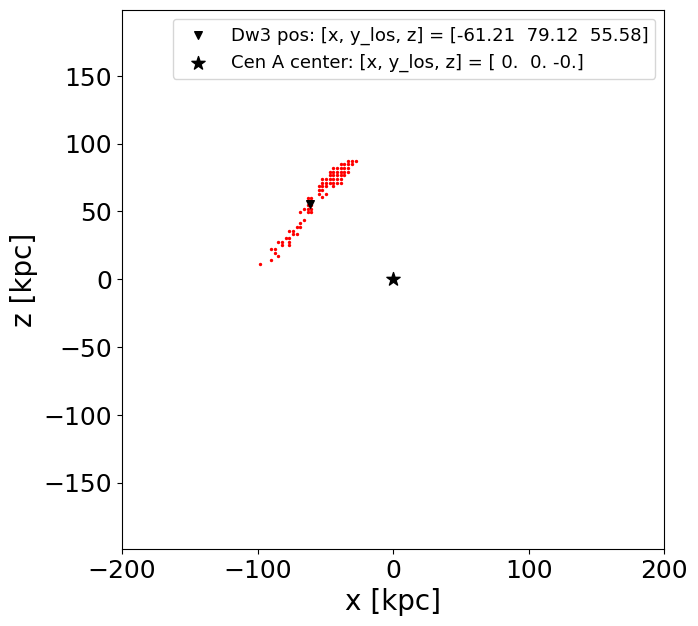

In [436]:
#Visualize red points, stream progenitor and host galaxy in galactocentric coordinate system
plt.figure(figsize=(7,7))
plt.axis('equal') 
# "hack" below to create a coordinate system where the skyplane is in x,z 
# and the perpendicular (line-of-sight, los) directions is along the y axis
plt.scatter(-red_points_GC.y.to(u.kpc), red_points_GC.z.to(u.kpc),  color='red', s=2)#, label="Bin Centers")
plt.scatter(-dw3_pos_GC.y.to(u.kpc), dw3_pos_GC.z.to(u.kpc), marker='v', color='black', s=30, label='Dw3 pos: [x, y_los, z] = ' + str(np.round(dw3_center,2)))
plt.scatter(c_CenA_GC.y,c_CenA_GC.z,marker='*', color='black', s=100, label='Cen A center: [x, y_los, z] = ' + str(np.round(c_CenA_center,2)))

plt.legend(fontsize=13)
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')

## Store red points and stream progenitor position for method for use in new notebook.